In [105]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import RandomizedSearchCV

In [166]:
scaler = MinMaxScaler()
df_train = pd.read_csv('train.csv')
df_synthetic = pd.read_csv('synthetic_data.csv')
df = pd.concat([df_train, df_synthetic], ignore_index=True)
df["Sex"] = df["Sex"].astype("category").cat.codes
df = df.drop(['id'], axis = 1)
cols_to_normalize = ["Length", "Weight", "Diameter", "Shucked Weight", "Viscera Weight", "Shell Weight"]
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
# df = pd.DataFrame(df)

In [167]:
df.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,1,0.732750,0.703390,0.3750,0.361254,0.301278,0.307185,0.291978,9.0
1,1,0.499914,0.466102,0.2750,0.129449,0.106590,0.106131,0.118087,8.0
2,2,0.657421,0.661017,0.3750,0.308837,0.268325,0.256427,0.232686,9.0
3,0,0.828624,0.864407,0.5000,0.632194,0.482179,0.509197,0.525660,11.0
4,1,0.582091,0.593220,0.3375,0.290243,0.283457,0.207647,0.207773,8.0


In [168]:
df.shape

(75051, 9)

<Axes: >

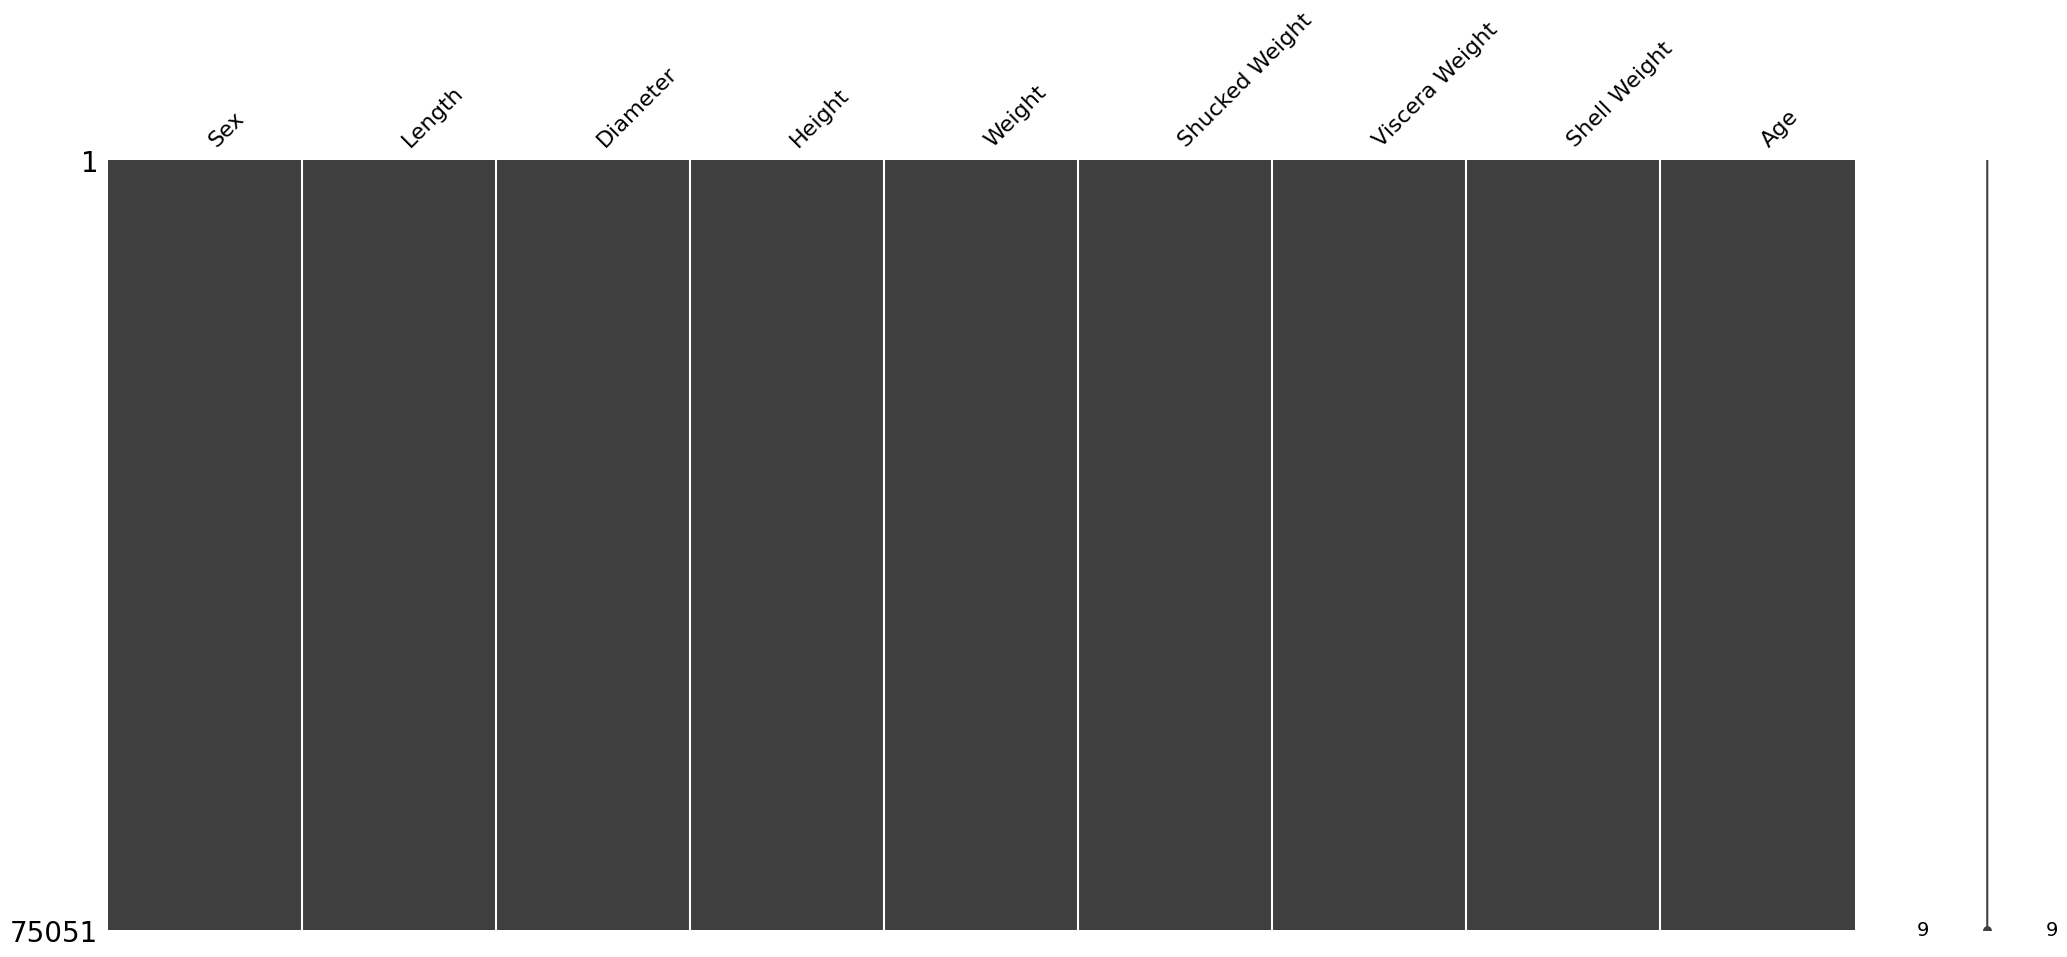

In [169]:
msno.matrix(df)

In [170]:
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

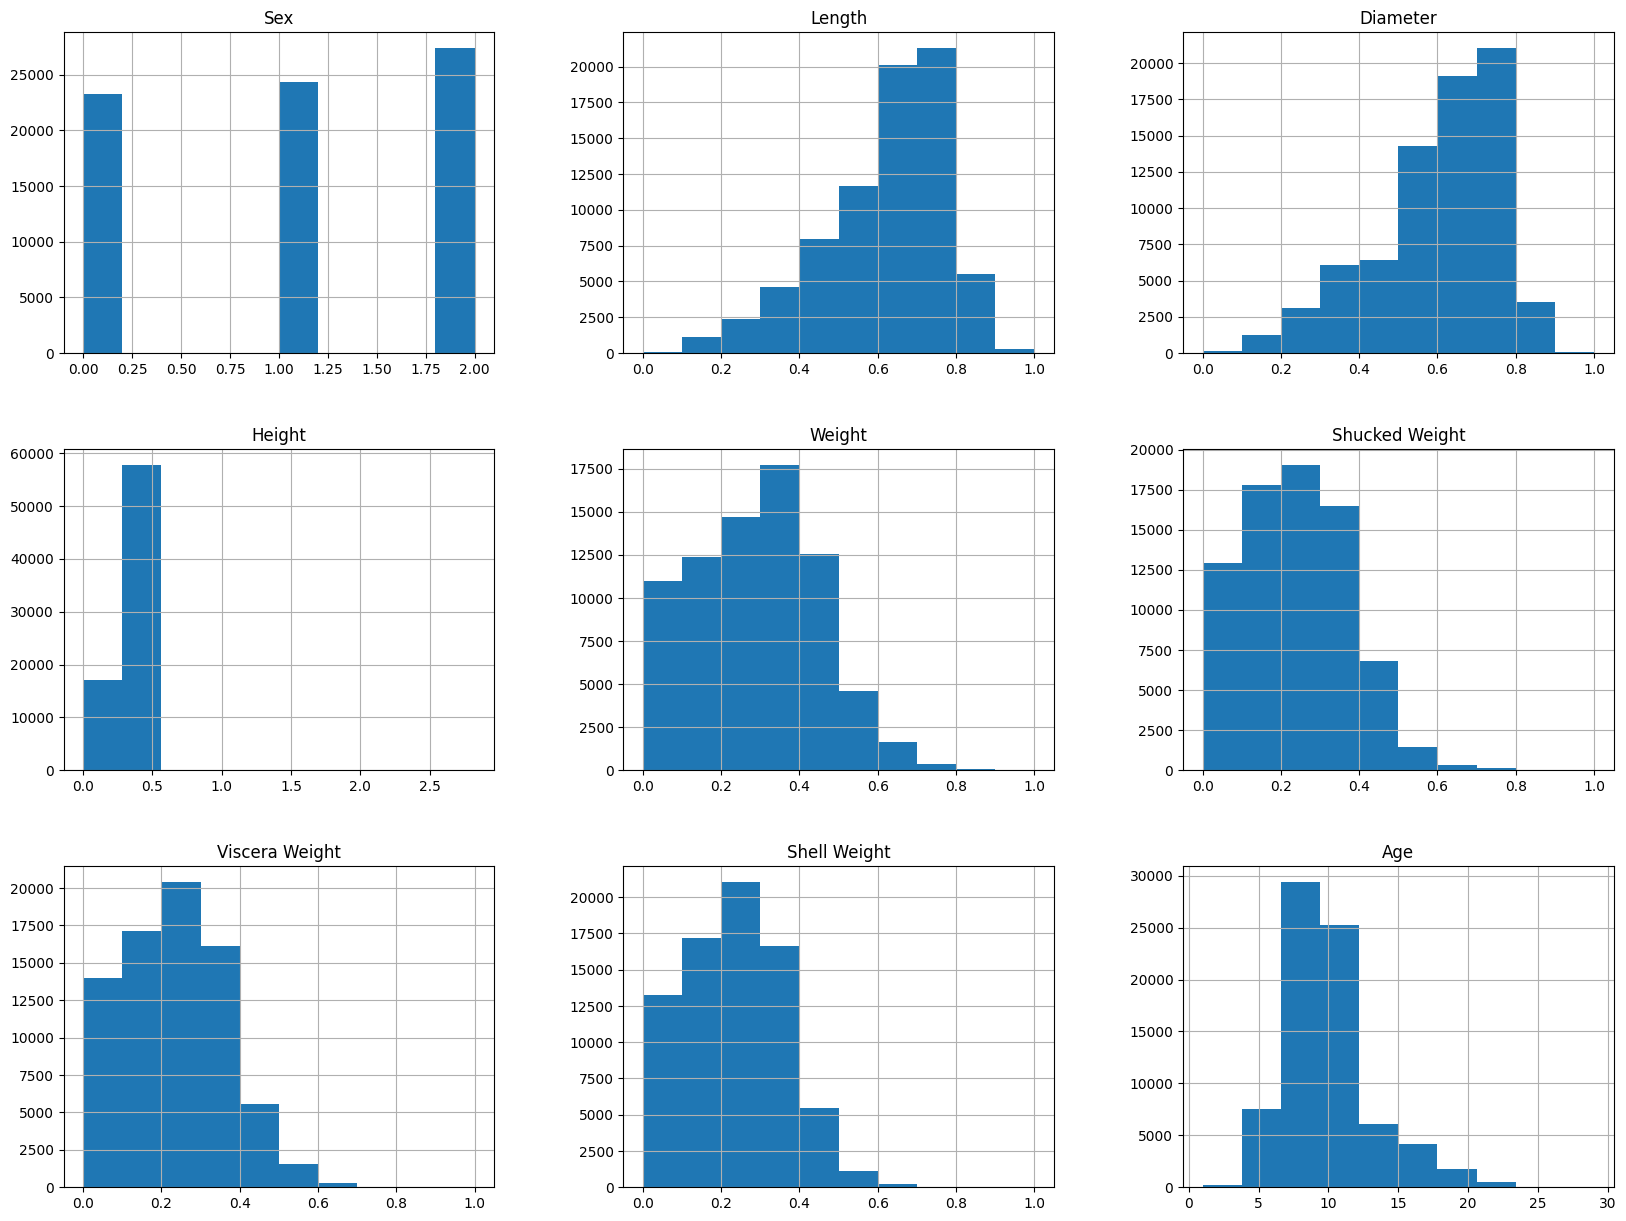

In [171]:
df.hist(bins=10, figsize=(20, 15))
plt.show()

In [172]:
df.describe()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,75051.000000,75051.000000,75051.000000,75051.000000,75051.000000,75051.000000,75051.000000,75051.000000,75051.000000
mean,1.055003,0.618934,0.601245,0.348003,0.291286,0.238875,0.233118,0.234737,9.966383
std,0.820417,0.157678,0.160979,0.092011,0.157923,0.133176,0.129790,0.125928,3.176685
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.527306,0.508475,0.287500,0.167168,0.134835,0.131180,0.138017,8.000000
50%,1.000000,0.650573,0.635593,0.362500,0.296618,0.234364,0.230059,0.241156,10.000000
75%,2.000000,0.739599,0.720339,0.412500,0.401098,0.332213,0.323006,0.317389,11.000000
max,2.000000,1.000000,1.000000,2.825000,1.000000,1.000000,1.000000,1.000000,29.000000


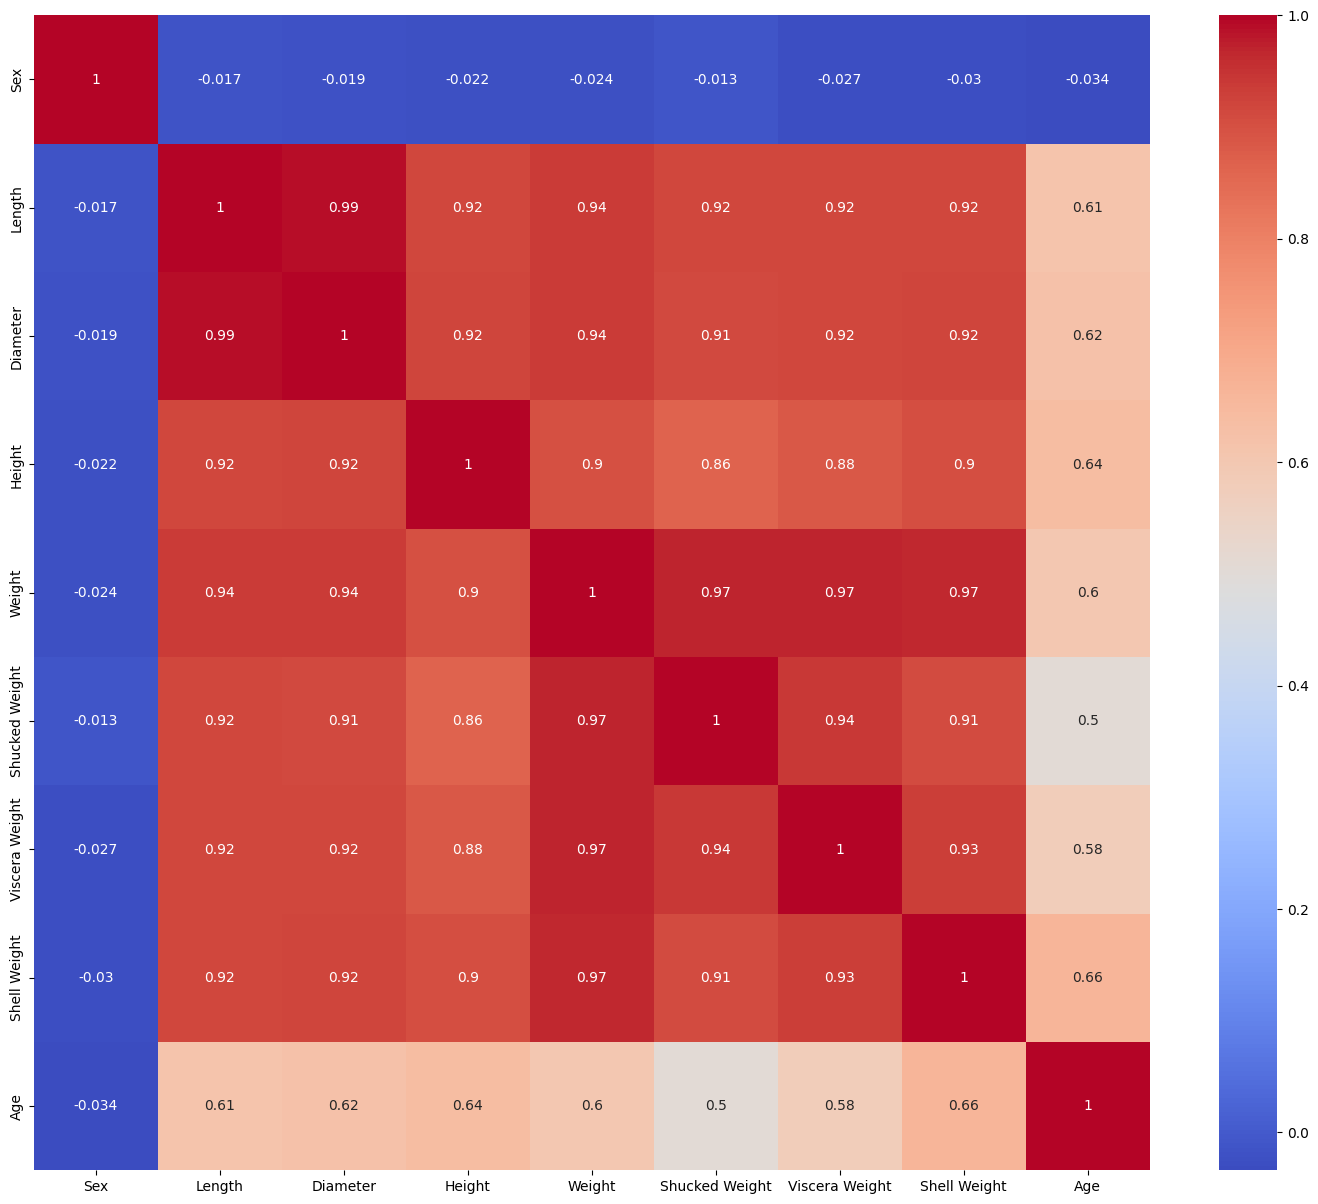

In [173]:
plt.figure(figsize=(18, 15))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()


In [174]:
df.shape

(75051, 9)

In [175]:
X = df.drop(['Age'], axis=1)
X.shape

(75051, 8)

In [176]:
y = df['Age']
y.shape

(75051,)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=42)

In [178]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
}
# specifing the parameters for XGBoost
xgboost_params = {
    'max_bin' : 230,
    'eval_metric': 'mae',  # specify the evaluation metric
#     'tree_method': 'gpu_hist',  # use GPU to build trees
#     'predictor' : 'gpu_predictor',
    'n_estimators': 179,
    'max_depth': 5,
    'learning_rate': 0.03811,
    'min_child_weight': 5,
    'subsample' : 0.623,
    'num_parallel_tree' : 1
}

# creating an XGBoost regressor
xgb_model = xgb.XGBRegressor(**params)
models = [
    ('Linear Regression', Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('linear_regression', LinearRegression())
])), ('XGB Regressor', xgb.XGBRFRegressor(**xgb_params)),
('Decision tree regressor', DecisionTreeRegressor(random_state=42)), 
('Random forest regressor', Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('random_forest_regressor', RandomForestRegressor())
])), 
('Support vector regression(SVR)', Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('svr_regressor', SVR())
])),
('Neural network', Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('estimator', MLPRegressor(learning_rate_init=0.05))
])),
('XGB Boost', xgb.XGBRegressor(**xgboost_params))]

In [179]:
test_df = pd.read_csv('test.csv')
test_df["Sex"] = test_df["Sex"].astype("category").cat.codes
test_df = test_df.drop(['id'], axis = 1)
test_df.shape
test_df.head()
submission = pd.read_csv('sample_submission.csv')

In [180]:
optimal_mae = 100000
for model in models:
    model[1].fit(X_train, y_train)
    y_pred = model[1].predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    test_pred = model[1].predict(test_df)
    submission['Age'] = test_pred
    submission.to_csv('submission_%s.csv' % model[0], index=False)
    print('%s, error: %f' % (model[0], mae))

Linear Regression, error: 1.585062
XGB Regressor, error: 1.481871
Decision tree regressor, error: 2.052597
Random forest regressor, error: 1.461383
Support vector regression(SVR), error: 1.413912
Neural network, error: 1.439643
XGB Boost, error: 1.419946


,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,1,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,0,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,0,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,1,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [56]:
neural_net_model = Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('estimator', MLPRegressor(learning_rate_init=0.05))
])
neural_net_model.fit(X_train, y_train)
test_pred = neural_net_model.predict(test_df)

In [61]:
xgboost_model = xgb.XGBRegressor(**xgboost_params)
xgboost_model.fit(X_train, y_train)
test_pred = xgboost_model.predict(test_df)

In [66]:
svr_model = Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('svr_regressor', SVR())
])
svr_model.fit(X_train, y_train)
test_pred = svr_model.predict(test_df)

In [67]:
test_pred.shape

(49368,)

In [68]:
submission = pd.read_csv('sample_submission.csv')
submission['Age'] = test_pred

In [69]:
submission.head()

,id,Age
0,74051,7.460731
1,74052,7.635007
2,74053,10.148165
3,74054,9.266821
4,74055,7.368388


In [70]:
submission.to_csv('submission_svr.csv', index=False)